# Client Retention Demo Using Python
In this demo, we will show Anaconda functionality accessing enterprise data from VSAM and DB2. The data stored in VSAM consists of 6,001 rows of customer information.  The data stored in DB2 consists of 20,000 rows of transaction data. The data is transformed and joined in a Pandas DataFrame, which is used to perform exploratory analyses. A random forest algorithm is then used to predict customer churn.

In [1]:
USERNAME="SPK8161"
PASSWORD="mave1234"
MDSS_SSID="AZK1"
DB2_SSID="DBBG"

import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore", category=PendingDeprecationWarning)

## Set up Mainframe Data Connections
This step will set up the VSAM and DB2 connections to access the data and load them into Pandas DataFrames.  The dsdbc module is delivered with the z/OS IzODA Anaconda distribution. It enables Python applications to access the z/OS IzODA Mainframe Data Service. The Data Service component (MDS) provides optimized, virtualized, and parallelized access to both IBM Z data sources and other off-platform data sources.

In [4]:
def cp1047_to_utf8(list):
    list_out = []
    for e in list:
        x = ()
        for i in e:
            if isinstance(i, (str,)):
                s = i.encode('utf16').decode('cp1047').encode('utf8').decode('utf16')[2:]
                x = x + (s,)
            else:
                x = x + (i,)
        list_out.append(x)
    return list_out

def load_data_from_mds(vtable_name, user, password, mds_id=MDSS_SSID):
    import dsdbc
    conn =dsdbc.connect(SSID=mds_id, user=user, password=password)
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM " + vtable_name)
    rows = cursor.fetchall()
    label = []
    for col in cursor.description: label.append(col[0].lower())
    conn.close()
    return pd.DataFrame(rows, columns=label)

def load_data_from_db2(table_name, user, password, mds_id=MDSS_SSID,  db2_id=DB2_SSID):
    import dsdbc
    conn =dsdbc.connect(SSID=mds_id, user=user, password=password, dsid=db2_id)
    cursor = conn.cursor()
    sql = "SELECT * FROM " + table_name
    #print(sql)
    cursor.execute(sql)
    rows = cp1047_to_utf8(cursor.fetchall())
    label = []
    for col in cursor.description: label.append(col[0].lower())
    conn.close()
    return pd.DataFrame(rows, columns=label)


***CSV File for Covid case***

Load covid 19 situation into a Pandas DataFrame.

In [8]:
import glob
print(glob.glob("owid-covid-latest.csv"))

['owid-covid-latest.csv']


In [47]:
covid_df = pd.read_csv (r'owid-covid-latest.csv')
df = pd.DataFrame(covid_df, columns= ['location','total_cases','total_deaths'])
# new_df = df.sort_values(["total_cases"], ascending=False)
# print(new_df.fillna(0))

## Aggregate statistics
Calculate a few aggregate statistics based on covid 19 cases and join the results to the covid 19 summaries DataFrame. (Until 25/9/2021)

In [67]:
# Total cases in Africa
africa_df = df[df["location"].isin(["Africa"])]
print(africa_df)

  location  total_cases  total_deaths
1   Africa    8233045.0      208523.0


In [68]:
# Total cases in Asia
asia_df = df[df["location"].isin(["Asia"])]
print(asia_df)

   location  total_cases  total_deaths
11     Asia   75061487.0     1115737.0


In [69]:
# Total cases in Europe
europe_df = df[df["location"].isin(["Europe"])]
print(europe_df)

   location  total_cases  total_deaths
65   Europe   58788902.0     1218752.0


In [70]:
# Total cases in European Union
euroUni_df = df[df["location"].isin(["European Union"])]
print(euroUni_df)

          location  total_cases  total_deaths
66  European Union   37677446.0      768177.0


In [71]:
# Total cases in North America
northAme_df = df[df["location"].isin(["North America"])]
print(northAme_df)

          location  total_cases  total_deaths
147  North America   51614749.0     1046376.0


In [72]:
# Total cases in Oceania
oceania_df = df[df["location"].isin(["Oceania"])]
print(oceania_df)

    location  total_cases  total_deaths
150  Oceania     171761.0        2074.0


In [73]:
# Total cases in South America
southAme_df = df[df["location"].isin(["South America"])]
print(southAme_df)

          location  total_cases  total_deaths
184  South America   37654349.0     1151417.0


In [74]:
# Total cases in World
world_df = df[df["location"].isin(["World"])]
print(world_df)

    location  total_cases  total_deaths
217    World  231525879.0     4742894.0


In [76]:
# Combine data
covidCD_df = pd.concat([africa_df, asia_df, europe_df, euroUni_df, northAme_df, oceania_df, southAme_df, world_df], ignore_index=True)
print(covidCD_df)

         location  total_cases  total_deaths
0          Africa    8233045.0      208523.0
1            Asia   75061487.0     1115737.0
2          Europe   58788902.0     1218752.0
3  European Union   37677446.0      768177.0
4   North America   51614749.0     1046376.0
5         Oceania     171761.0        2074.0
6   South America   37654349.0     1151417.0
7           World  231525879.0     4742894.0


### Bar Chart
We begin our exploration of the data set by creating a bar chart of covid 19 cases associated histograms. 

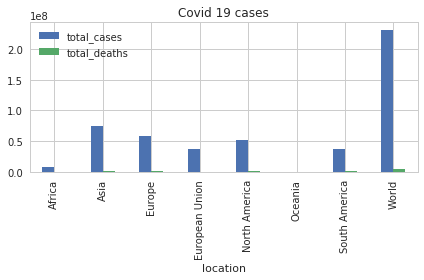

In [101]:
# Bar chart for Covid 19
covidCD_df.plot.bar(x = 'location',
                    title= 'Covid 19 cases')
plt.tight_layout()
plt.show()

### Pie Chart
We begin our exploration of the data set by creating a pie chart of covid 19 cases.

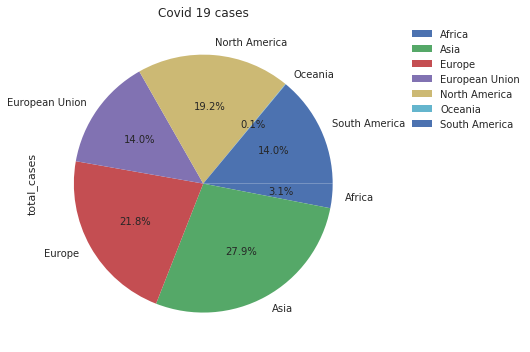

In [130]:
# Total cases
pie_df = pd.DataFrame(covidCD_df, columns= ['location','total_cases'])
pie_df = pie_df.head(7)
pie_df.plot.pie(x = 'location',\
                y = 'total_cases',\
                title = 'Covid 19 cases',\
                labels = covidCD_df['location'],
                figsize = (5, 5),\
                autopct = '%.1f%%',
                counterclock = False)
plt.tight_layout()
plt.legend(loc="upper right",\
           fontsize=10,\
           bbox_to_anchor=(1.5,1.0),\
           borderaxespad=0.3)
plt.show()

### Correlations
Next, we compute the correlation coefficients between each variable and create a color-coded correlation matrix. 

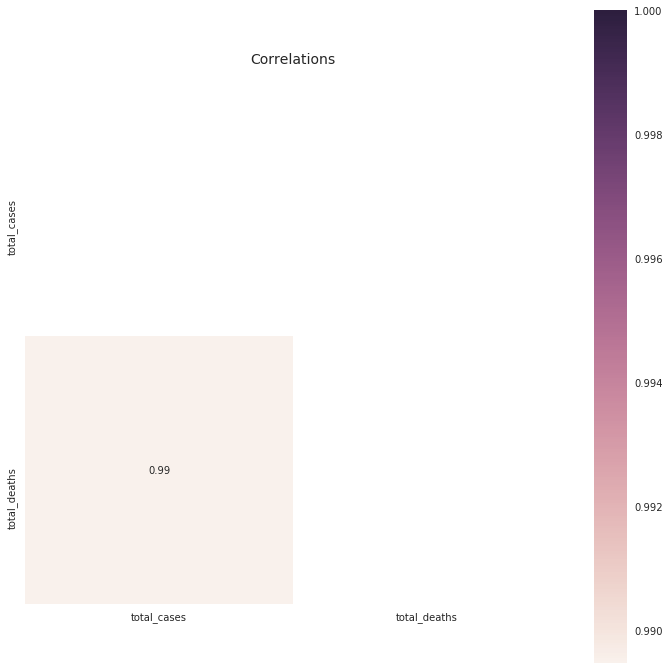

In [78]:
corr = covidCD_df.corr()

# only show lower triangle
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(12,12))
ax = sns.heatmap(corr, mask=mask, square=True, annot=True, fmt='.2f',
                 cbar=True,
                 ax=ax)
title = ax.set_title('Correlations', size=14)